In [1]:
# set up enviroment
from __future__ import division
import sys
import numpy as np
import pandas as pd 
import scipy
import importlib
import scanpy as sc

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib_venn import venn2

from sklearn.manifold import TSNE
import sklearn

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(figsize=(6,7),dpi_save=600)

scanpy==1.4.6 anndata==0.7.1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
adata_all = sc.read_h5ad('../data/adata_all_panPN_annotated_final.h5ad')
adata_all

AnnData object with n_obs × n_vars = 3633 × 17474 
    obs: 'batch', 'genotype', 'stage', 'n_counts', 'n_genes', 'PN_type', 'MARS', 'HDBSCAN', 'MARS_2way_matched', 'MARS_2way_matched_PN_type', 'lineage', '24h_HDBSCAN', 'matched_type_with_stage', 'mannually_matched'
    var: 'highly_variable'
    uns: '24h_HDBSCAN_colors', 'HDBSCAN_colors', 'MARS_2way_matched_PN_type_colors', 'MARS_2way_matched_colors', 'MARS_colors', 'PN_type_colors', 'mannually_matched_colors', 'stage_colors'
    obsm: 'X_tsne'

In [4]:
def load_list(infile):
    X = []
    with open(infile) as f:
        for line in f:
            X.append(line.rstrip())
    return X

CSMs = load_list("../resources/CSMs.txt")
TFs = load_list("../resources/TFs.txt")

In [5]:
def write_set_to_file(s, filename):
    with open(filename, 'w') as out:
        for x in s:
            out.write("%s\n" % x)

# adult

In [6]:
adata_adult = adata_all[(adata_all.obs['stage'] == 'adult') & 
                        ((adata_all.obs['PN_type'] != 'vPN') & (adata_all.obs['PN_type'] != 'APL') & (adata_all.obs['PN_type'] != 'MARS_19')) ]

In [7]:
adata_adult

View of AnnData object with n_obs × n_vars = 556 × 17474 
    obs: 'batch', 'genotype', 'stage', 'n_counts', 'n_genes', 'PN_type', 'MARS', 'HDBSCAN', 'MARS_2way_matched', 'MARS_2way_matched_PN_type', 'lineage', '24h_HDBSCAN', 'matched_type_with_stage', 'mannually_matched'
    var: 'highly_variable'
    uns: '24h_HDBSCAN_colors', 'HDBSCAN_colors', 'MARS_2way_matched_PN_type_colors', 'MARS_2way_matched_colors', 'MARS_colors', 'PN_type_colors', 'mannually_matched_colors', 'stage_colors'
    obsm: 'X_tsne'

In [8]:
sc.tl.rank_genes_groups(adata_adult,groupby='MARS', method='wilcoxon',n_genes=5000)

ranking genes


Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


In [9]:
pval = pd.DataFrame(adata_adult.uns['rank_genes_groups']['pvals_adj'])

In [10]:
genes = pd.DataFrame(adata_adult.uns['rank_genes_groups']['names'])

In [11]:
# get only genes that have adjusted p-value less than 0.01
all_sig_genes_adult = set()
for MARS in genes.columns:
    curr_sig_genes = set(genes[MARS][pval[MARS] < 0.01])
#     print('number of genes in MARS cluster ',MARS,' :', len(curr_sig_genes))
    all_sig_genes_adult = all_sig_genes_adult.union(curr_sig_genes)

In [12]:
len(all_sig_genes_adult)

518

In [13]:
# write_set_to_file(all_sig_genes_adult,"../output/adult_pval10E-2.txt")

In [14]:
print('number of CSMs in adult DE genes: ',len(set(all_sig_genes_adult).intersection(set(CSMs))))
print('number of TFs in adult DE genes: ',len(set(all_sig_genes_adult).intersection(set(TFs))))

number of CSMs in adult DE genes:  88
number of TFs in adult DE genes:  43


# 24h

In [15]:
adata_24h = adata_all[(adata_all.obs['stage'] == '24h') & 
                        ((adata_all.obs['PN_type'] != 'vPN') & (adata_all.obs['PN_type'] != 'APL') & (adata_all.obs['MARS'] != '17'))]

In [16]:
sc.tl.rank_genes_groups(adata_24h,groupby='MARS', method='wilcoxon',n_genes=5000)
pval = pd.DataFrame(adata_24h.uns['rank_genes_groups']['pvals_adj'])
genes = pd.DataFrame(adata_24h.uns['rank_genes_groups']['names'])

ranking genes


Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


In [17]:
all_sig_genes = set()
for MARS in genes.columns:
    curr_sig_genes = set(genes[MARS][pval[MARS] < 0.01])
    all_sig_genes = all_sig_genes.union(curr_sig_genes)

In [18]:
len(all_sig_genes)

504

In [19]:
# write_set_to_file(all_sig_genes,"../output/24h_APF_pval10E-1.txt")

In [20]:
print('number of CSMs in 24h APF DE genes: ',len(set(all_sig_genes).intersection(set(CSMs))))
print('number of TFs in 24h APF DE genes: ',len(set(all_sig_genes).intersection(set(TFs))))

number of CSMs in 24h APF DE genes:  150
number of TFs in 24h APF DE genes:  57


In [21]:
# only_adult = set(all_sig_genes_adult).difference(set(all_sig_genes))
# write_set_to_file(only_adult,"../output/adult_only_pval10E-1.txt")

In [22]:
# only_24h = set(all_sig_genes).difference(set(all_sig_genes_adult))
# write_set_to_file(only_24h,"../output/24h_only_pval10E-1.txt")

In [23]:
len(set(all_sig_genes).intersection(set(all_sig_genes_adult)))

156

In [24]:
# common = set(all_sig_genes).intersection(set(all_sig_genes_adult))
# write_set_to_file(common,"../output/24h_adult_common_pval10E-1.txt")

# Venn Diagram and CSMs/TFs percentage

In [25]:
adult_CSMs = set(all_sig_genes_adult).intersection(set(CSMs))
adult_TFs = set(all_sig_genes_adult).intersection(set(TFs))

In [26]:
pupa_CSMs = set(all_sig_genes).intersection(set(CSMs))
pupa_TFs = set(all_sig_genes).intersection(set(TFs))

In [27]:
print('number of CSMs found in both adult and 24h APF: ',len(set(adult_CSMs).intersection(set(pupa_CSMs))))
print('number of CSMs found in 24h APF: ',len(set(pupa_CSMs)))
print('number of CSMs found in adult: ',len(set(adult_CSMs)))
print('number of TFs found in both adult and 24h APF: ',len(set(adult_TFs).intersection(set(pupa_TFs))))
print('number of TFs found in 24h APF: ',len(set(pupa_TFs)))
print('number of TFs found in adult: ',len(set(adult_CSMs)))

number of CSMs found in both adult and 24h APF:  51
number of CSMs found in 24h APF:  150
number of CSMs found in adult:  88
number of TFs found in both adult and 24h APF:  29
number of TFs found in 24h APF:  57
number of TFs found in adult:  88


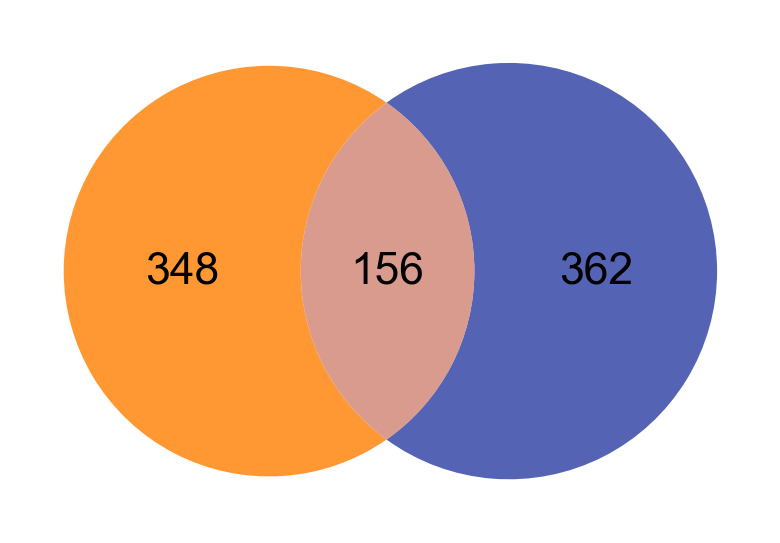

In [28]:
v2 = venn2([all_sig_genes,all_sig_genes_adult], set_labels=('',''),set_colors=('#ff7f00','#2A3CA1'),alpha=0.8)
for text in v2.subset_labels:
    text.set_fontsize(20)
# plt.savefig('figures/figure_10/venn/all_DE_genes.pdf', bbox_inches='tight')

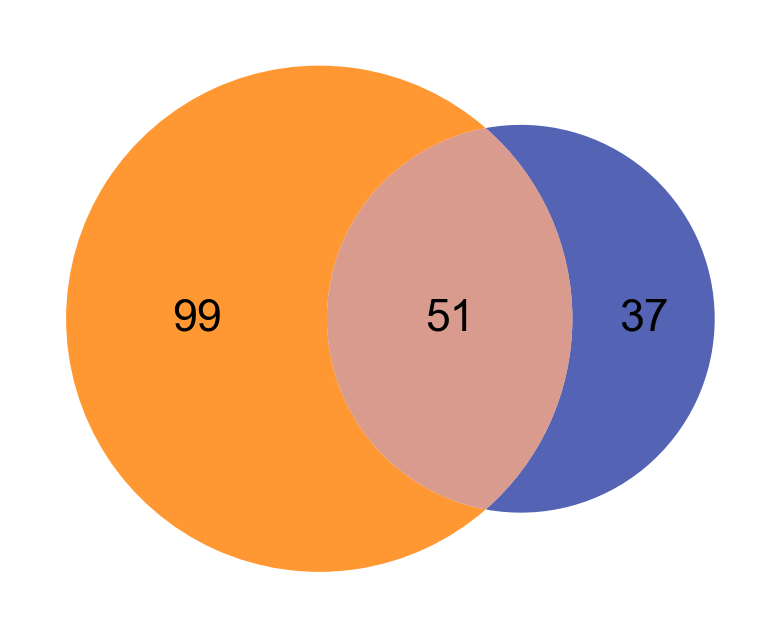

In [29]:
v2 = venn2([pupa_CSMs,adult_CSMs], set_labels=('',''),set_colors=('#ff7f00','#2A3CA1'),alpha=0.8)
for text in v2.subset_labels:
    text.set_fontsize(20)
# plt.savefig('figures/figure_10/venn/all_CSM.pdf', bbox_inches='tight')

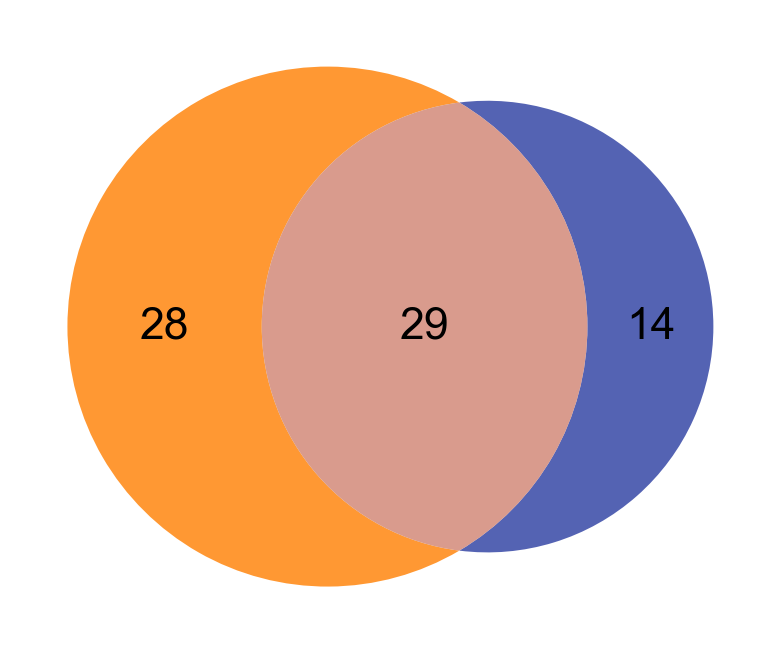

In [30]:
v2 = venn2([pupa_TFs,adult_TFs], set_labels=('',''),set_colors=('#ff7f00','#2A3CA1'),alpha=0.8)
for text in v2.subset_labels:
    text.set_fontsize(20)
# plt.savefig('figures/figure_10/venn/all_TFs.pdf', bbox_inches='tight')

In [31]:
print('percentage of CSMs in adult DE genes: ',
      str(len(set(all_sig_genes_adult).intersection(set(CSMs)))/len(all_sig_genes_adult)))
print('percentage of CSMs in 24h APF DE genes: ',
      str(len(set(all_sig_genes).intersection(set(CSMs)))/len(all_sig_genes)))
print('percentage of CSMs in genome: ',len(CSMs)/len(adata_adult.var_names))

print('percentage of TFs in adult DE genes: ',
      str(len(set(all_sig_genes_adult).intersection(set(TFs)))/len(all_sig_genes_adult)))
print('percentage of TFs in 24h APF DE genes: ',
      str(len(set(all_sig_genes).intersection(set(TFs)))/len(all_sig_genes)))
print('percentage of TFs in genome: ',len(TFs)/len(adata_adult.var_names))

percentage of CSMs in adult DE genes:  0.16988416988416988
percentage of CSMs in 24h APF DE genes:  0.2976190476190476
percentage of CSMs in genome:  0.05465262675975736
percentage of TFs in adult DE genes:  0.08301158301158301
percentage of TFs in 24h APF DE genes:  0.1130952380952381
percentage of TFs in genome:  0.059803136087902026


In [32]:
common = set(all_sig_genes).intersection(set(all_sig_genes_adult))

In [33]:
print('percentage of CSMs in both 24h APF and adult DE genes: ',
      str(len(set(common).intersection(set(CSMs)))/len(common)))
print('percentage of TFs in both 24h APF and adult DE genes: ',
      str(len(set(common).intersection(set(TFs)))/len(common)))

percentage of CSMs in both 24h APF and adult DE genes:  0.3269230769230769
percentage of TFs in both 24h APF and adult DE genes:  0.1858974358974359


<BarContainer object of 2 artists>

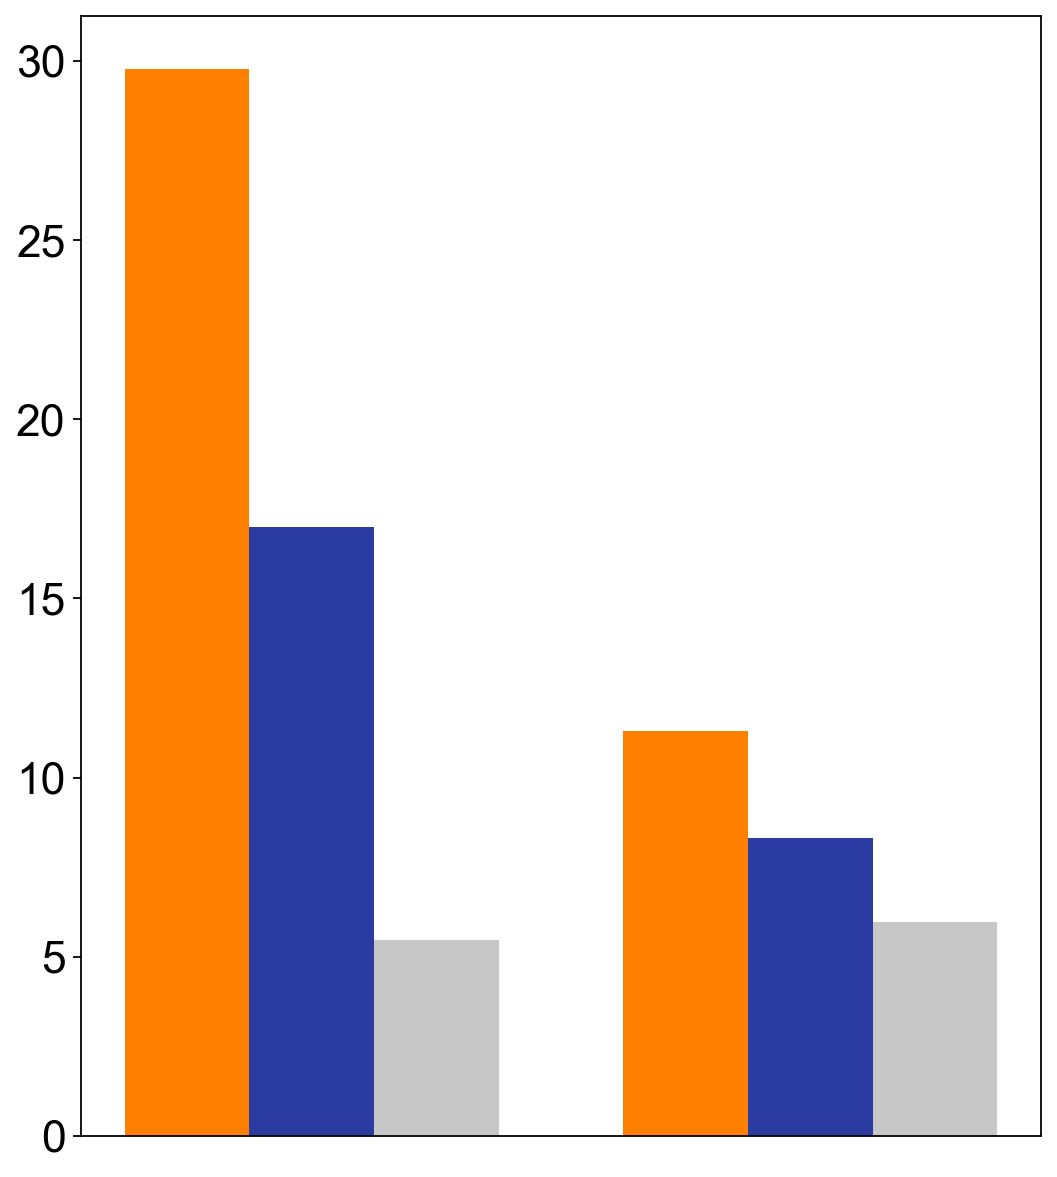

In [34]:
data = [[29.762, 11.31],
[16.988, 8.301],
[5.465, 5.98]]
X = np.arange(2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.grid(False)
ax.set_xticks([])
ax.tick_params(axis='both', which='major', labelsize=20)
ax.bar(X + 0.00, data[0], color = '#ff7f00', width = 0.25)
ax.bar(X + 0.25, data[1], color = '#2A3CA1', width = 0.25)
ax.bar(X + 0.5, data[2], color = '#c7c7c7', width = 0.25)
# fig.savefig('figures/figure_9/percentage_CSM_TF_adj_pval.pdf', bbox_inches='tight')

<BarContainer object of 2 artists>

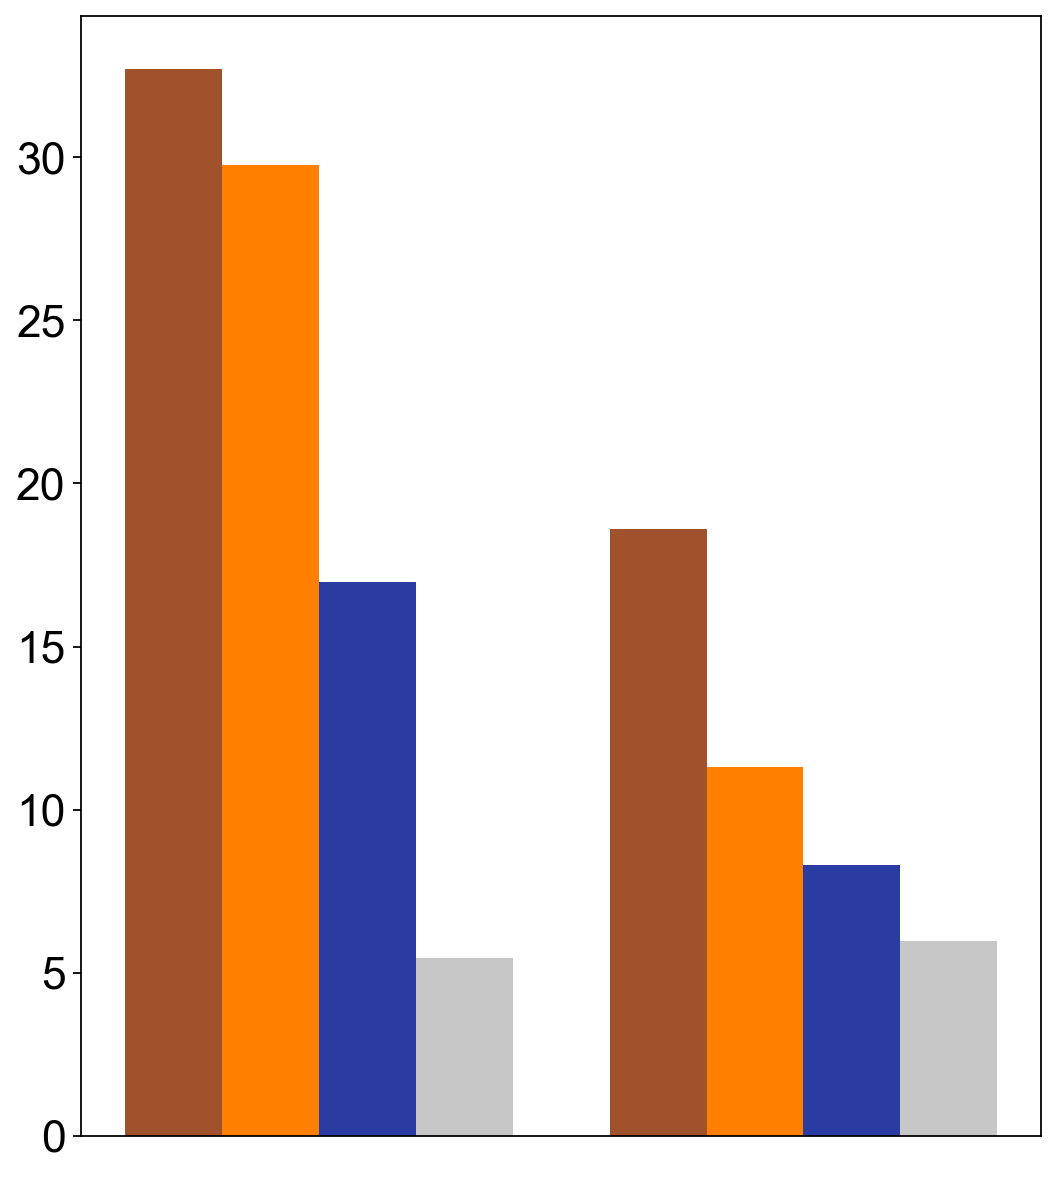

In [35]:
data = [[32.692,18.590],
        [29.762, 11.31],
        [16.988, 8.301],
        [5.465, 5.98]]
X = np.arange(2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.grid(False)
ax.set_xticks([])
ax.tick_params(axis='both', which='major', labelsize=20)
ax.bar(X + 0.00, data[0], color = '#a0522d', width = 0.2)
ax.bar(X + 0.2, data[1], color = '#ff7f00', width = 0.2)
ax.bar(X + 0.4, data[2], color = '#2A3CA1', width = 0.2)
ax.bar(X + 0.6, data[3], color = '#c7c7c7', width = 0.2)
# fig.savefig('figures/figure_9/percentage_CSM_TF_adj_pval_withoverlap.pdf', bbox_inches='tight')

In [42]:
genes = ['CG15537','hig','CG17544','RapGAP1','CG11984','CG42594']
for gene in genes:
    print(gene, str('hig' in all_sig_genes_adult),',',str('hig' in all_sig_genes))

CG15537 True , True
hig True , True
CG17544 True , True
RapGAP1 True , True
CG11984 True , True
CG42594 True , True


# GO term analysis

GO terms were obtained by uploading the gene set saved obove to FlyMine
https://www.flymine.org/flymine/begin.do

In [36]:
def load_Flymine(infile):
    terms = []
    pvalues = []
    num_genes = []
    with open(infile) as f:
        for line in f:
            term = line.rstrip().split("\t")[0]
            pvalue = float(line.rstrip().split("\t")[1])
            n = len(line.rstrip().split("\t")[2].split(","))
            terms.append(term)
            pvalues.append(pvalue)
            num_genes.append(n)
    df = pd.DataFrame({"term":terms, "pvalue": pvalues, "num_genes": num_genes})
    df.sort_values("pvalue", inplace=True, ascending=True)
    return df

In [37]:
GO_24hAPF = load_Flymine("../data/24h_vs_adult_compare/24h_only_biological_process.tsv")
GO_common = load_Flymine("../data/24h_vs_adult_compare/24h_adult_common_biological_process.tsv")
GO_adult = load_Flymine("../data/24h_vs_adult_compare/adult_only_biological_process.tsv")
GO_24hAPF.term[0] = GO_24hAPF.term[0][1:]
GO_common.term[0] = GO_common.term[0][1:]
GO_adult.term[0] = GO_adult.term[0][1:]

In [38]:
num_hits = 10

Text(0.5, 0, '-log10(P value)')

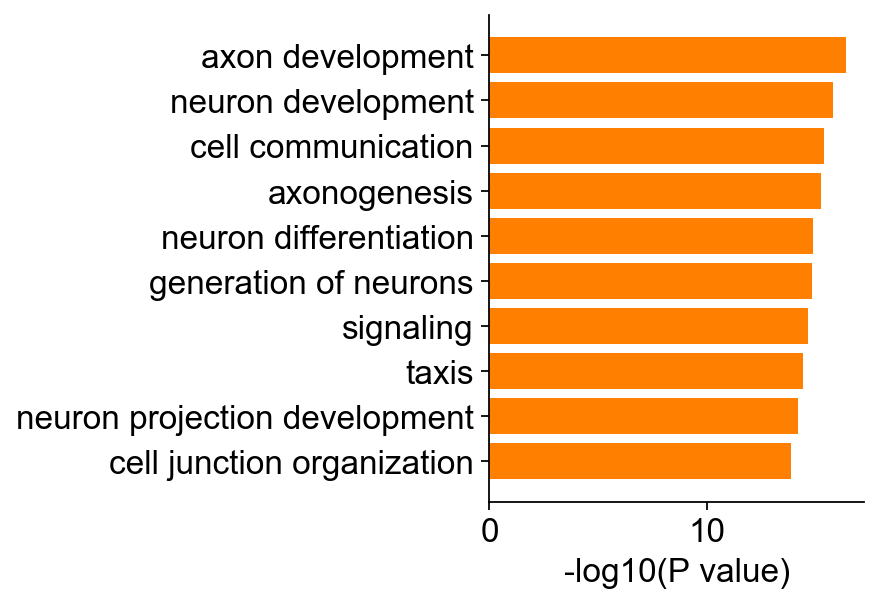

In [39]:
myData = GO_24hAPF.head(n=num_hits)[::-1]

x = np.array(range(myData.shape[0]))
y = -np.log10(myData["pvalue"])
xticklabels = list(myData["term"])

fig, ax = plt.subplots(1, 1, figsize=(3,4))#5,8
ax.grid(False)
ax.barh(x, y, color= '#ff7f00')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_yticks(x)
ax.set_yticklabels(xticklabels)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("-log10(P value)", fontsize=15)

# fig.savefig('figures/figure_10/GO_term/24h_only_top10.pdf', bbox_inches='tight')

Text(0.5, 0, '-log10(P value)')

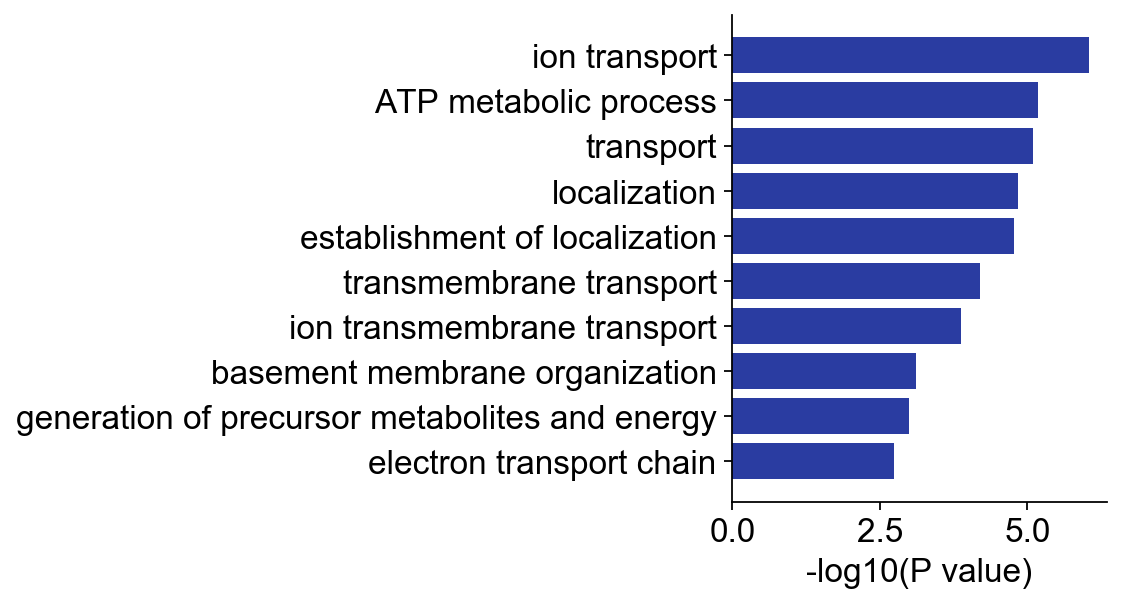

In [40]:
# P values
myData = GO_adult.head(n=num_hits)[::-1]

x = np.array(range(myData.shape[0]))
y = -np.log10(myData["pvalue"])
xticklabels = list(myData["term"])

fig, ax = plt.subplots(1, 1, figsize=(3,4))
ax.grid(False)
ax.barh(x, y, color= '#2A3CA1')
ax.set_yticks(x)
ax.set_yticklabels(xticklabels)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel("-log10(P value)", fontsize=15)

# fig.savefig('figures/figure_10/GO_term/adult_only_10.pdf', bbox_inches='tight')

Text(0.5, 0, '-log10(P value)')

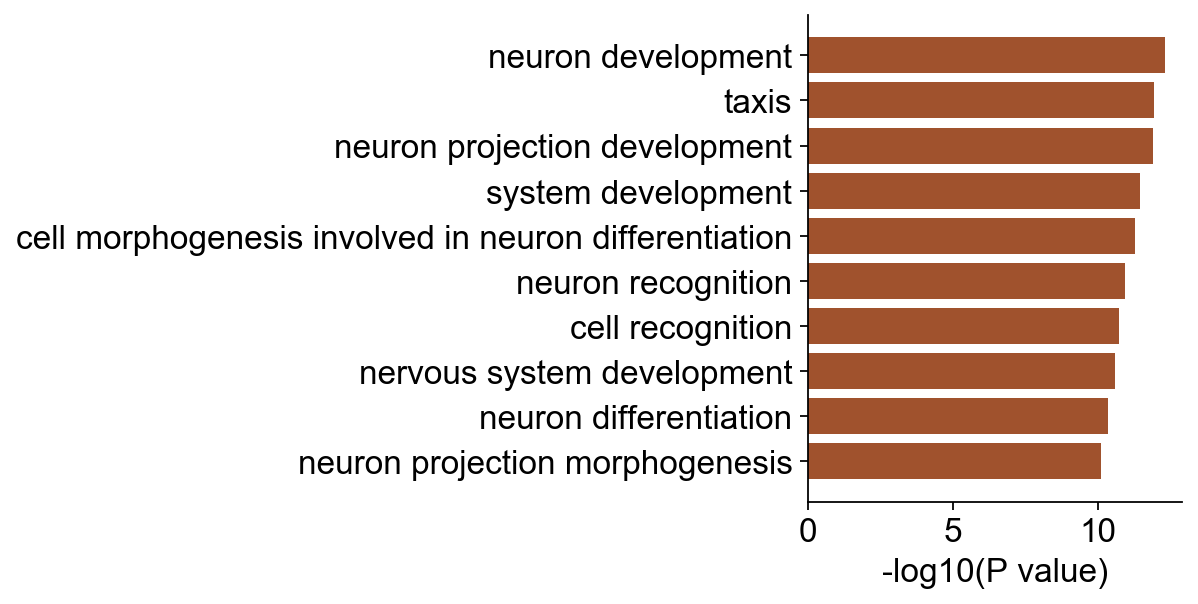

In [41]:
# P values
myData = GO_common.head(n=num_hits)[::-1]

x = np.array(range(myData.shape[0]))
y = -np.log10(myData["pvalue"])
xticklabels = list(myData["term"])

fig, ax = plt.subplots(1, 1, figsize=(3,4)) 
ax.grid(False)
ax.barh(x, y, color= '#a0522d')
ax.set_yticks(x)
ax.set_yticklabels(xticklabels)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel("-log10(P value)", fontsize=15)

# fig.savefig('figures/figure_10/GO_term/common_top10.pdf', bbox_inches='tight')

# adult only

In [42]:
adult_only = list(set(all_sig_genes_adult).difference(all_sig_genes))

In [47]:
food_PNs = ['VC2','VM7 or VM5v #2','VM7 or VM5v #1','VA6','DL1','VM2','DM6']
phero_PNs = ['DC3 and VA1d', 'DA1','VA1v']
danger_PN = ['D']
all_decoded_PN = food_PNs 
adata_adult.obs['fru_phero_PNs'] = adata_adult.obs['PN_type'].cat.reorder_categories(all_decoded_PN)
adata_adult.obs['fru_phero_PNs'] = adata_adult.obs['PN_type'].cat.remove_categories(others)
adata_adult.obs['fru_phero_PNs'] = adata_adult.obs['PN_type'].cat.reorder_categories(all_decoded_PN)
adata_adult.obs['fru_phero_PNs'] = adata_adult.obs['PN_type'].cat.remove_categories(others)
adata_adult.obs['fru_phero_PNs'] = adata_adult.obs['fru_phero_PNs'].cat.reorder_categories(food_PNs+phero_PNs)

NameError: name 'all_decoded_PN' is not defined

In [83]:
# sc.pl.dotplot(adata_adult,var_names=adult_only[350:400],groupby='fru_phero_PNs')

In [43]:
interesting_genes = ['CG42594','CG42340','CG43373','sNPF-R','gammaSnap2','hig','CG15537']

In [44]:
sc.set_figure_params(dpi_save=600)

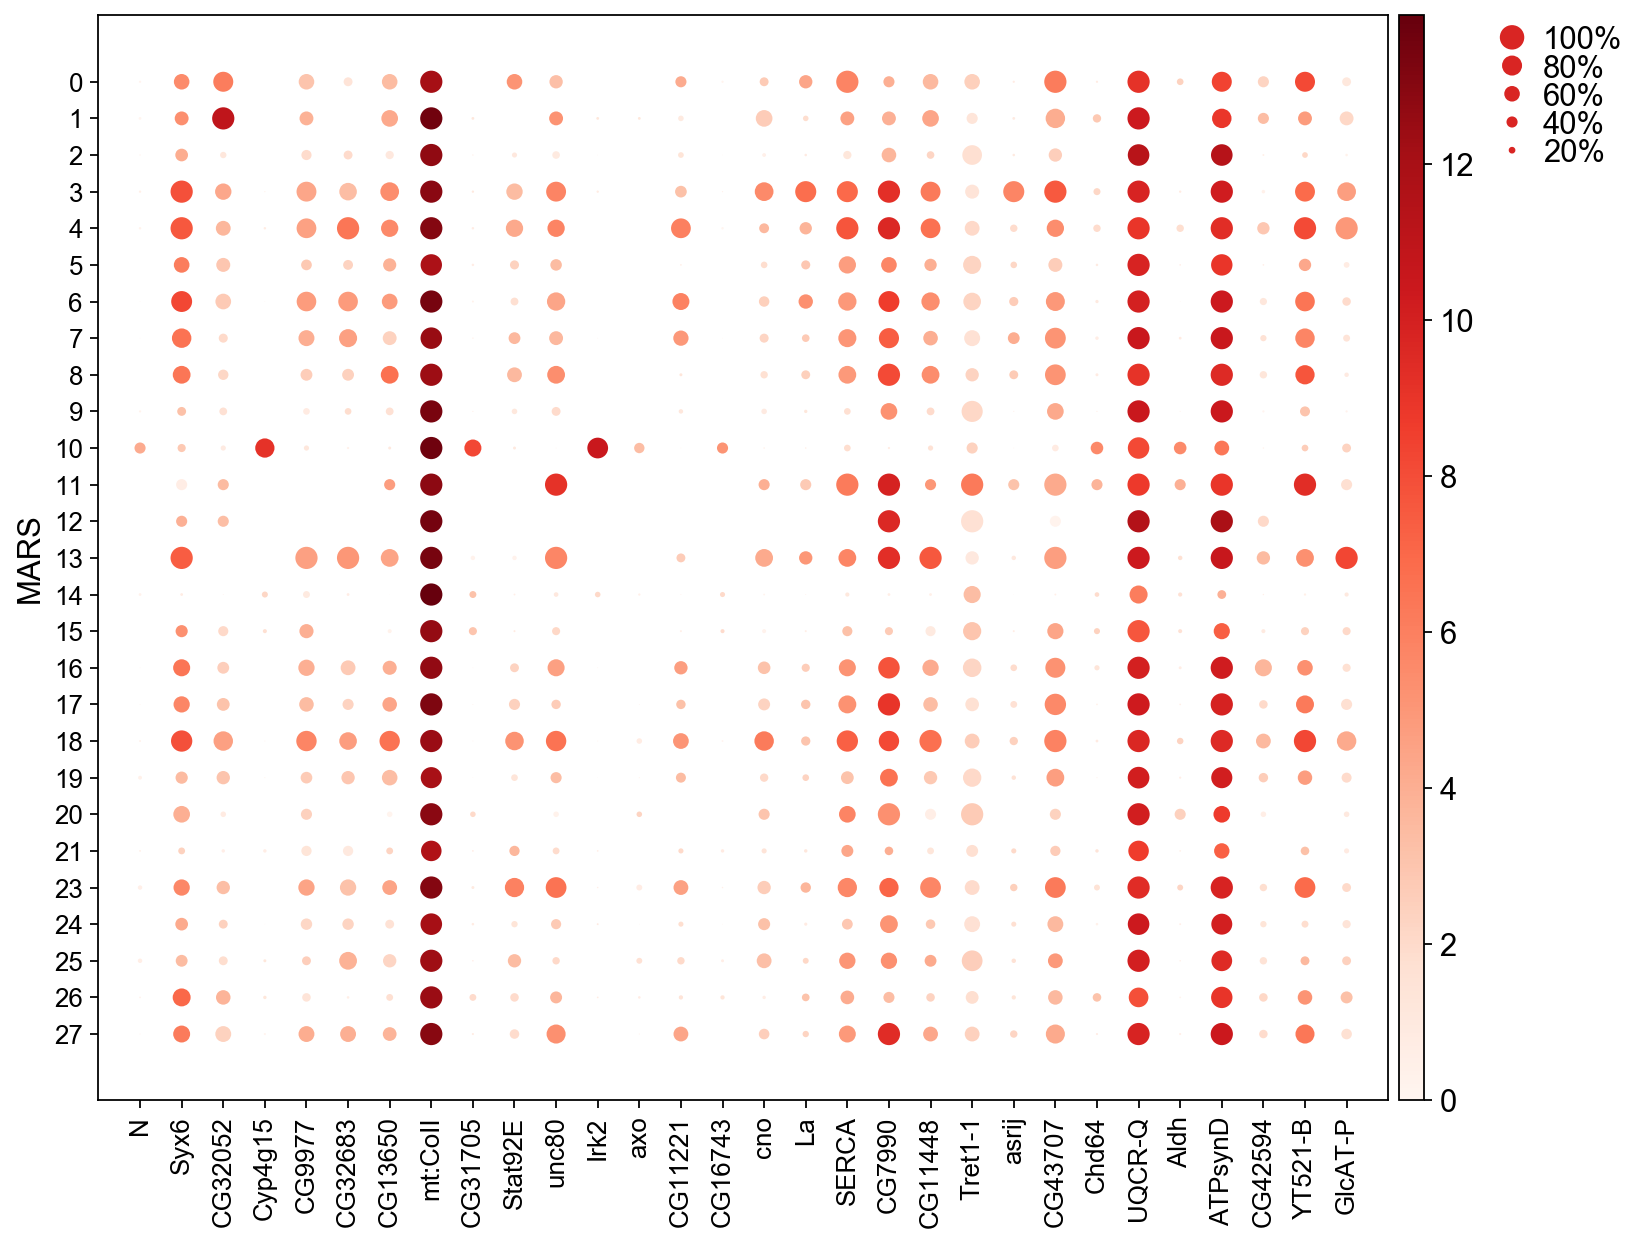

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[10.5, 0, 0.2, 0.5, 0.25])

In [45]:
sc.pl.dotplot(adata_adult,var_names=adult_only[:30], groupby='MARS')

In [46]:
sc.pl.dotplot(adata_adult,var_names=interesting_genes, groupby='fru_phero_PNs')#,save='_selected_genes.pdf')

ValueError: groupby has to be a valid observation. Given fru_phero_PNs, valid observations: ['batch', 'genotype', 'stage', 'n_counts', 'n_genes', 'PN_type', 'MARS', 'HDBSCAN', 'MARS_2way_matched', 'MARS_2way_matched_PN_type', 'lineage', '24h_HDBSCAN', 'matched_type_with_stage', 'mannually_matched']

In [79]:
adata_24h = adata_all[adata_all.obs.stage == '24h']

In [80]:
food_PNs = ['VA6', 'VC2', 'VM7 or VM5v #2', 'VM2', 'VM7 or VM5v #1', 'D', 'DM6', 'DL1']
phero_PNs = ['VA1v', 'DA1_fru+','DA1_fru-', 'DC3', 'VA1d']
all_24h = set(adata_24h.obs['PN_type'].cat.categories)
rest = all_24h.difference(set(food_PNs+phero_PNs))

In [81]:
adata_24h.obs['fru_phero_PNs'] = adata_24h.obs['PN_type'].cat.reorder_categories(list(all_24h))
adata_24h.obs['fru_phero_PNs'] = adata_24h.obs['fru_phero_PNs'].cat.remove_categories(list(rest))
adata_24h.obs['fru_phero_PNs'] = adata_24h.obs['fru_phero_PNs'].cat.reorder_categories(food_PNs+phero_PNs)

Trying to set attribute `.obs` of view, copying.


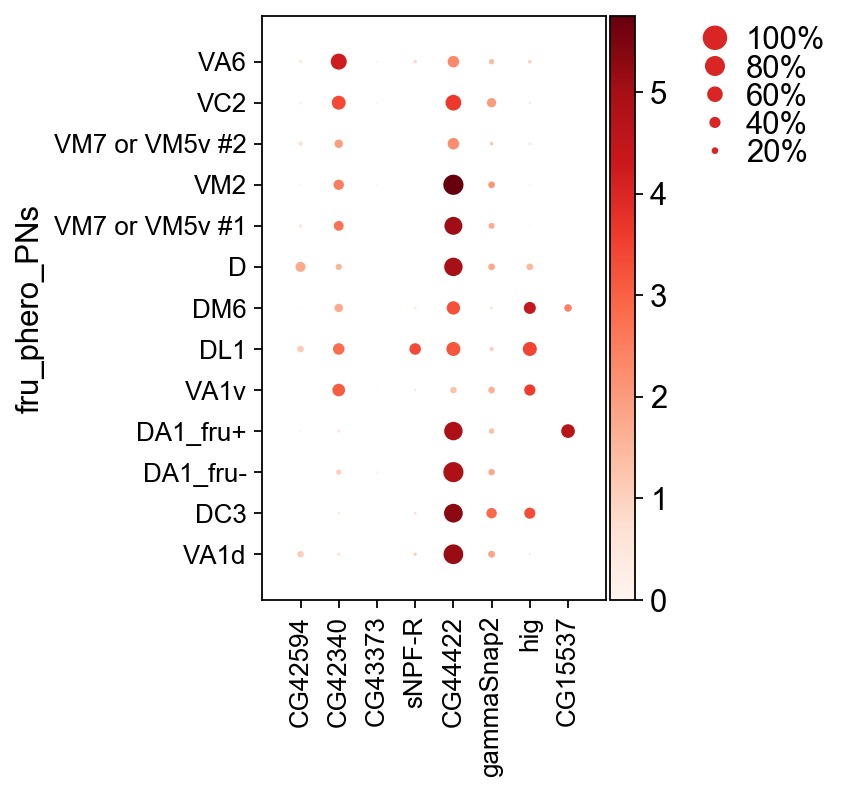

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[2.8, 0, 0.2, 0.5, 0.25])

In [82]:
sc.pl.dotplot(adata_24h,var_names=interesting_genes,groupby='fru_phero_PNs')